# Covid-19 United States Growth Modeling

### Data Source:
#### 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering

Link: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import numpy.random as npr
import pandas as pd
from scipy.optimize import leastsq

import datetime
import warnings

from lib import get_or_update_source_data, logistic4, residuals, peval

warnings.filterwarnings('ignore')

In [2]:
get_or_update_source_data()

Updating source data


In [3]:
df = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv') 

## Report Update Information:

In [4]:
print(f'Report Generated On:\t\t{datetime.datetime.now().strftime("%m/%d/%y")}\nData Source Updated On:\t\t{df.columns[-1]}')

Report Generated On:		03/23/20
Data Source Updated On:		3/22/20


### On 3/10/20, data stopped being reported by county and began reporting at the state level:

Source: https://github.com/CSSEGISandData/COVID-19/issues/382

In [5]:
us_states_by_county = df[(df["Country/Region"]=='US') & (df["Province/State"].str.contains(','))]

In [6]:
us_states = df[(df["Country/Region"]=='US') & (df["Province/State"].str.contains(',').apply(lambda x: not x))]

In [7]:
states_sum_by_county = us_states_by_county.sum().to_frame().drop(["Province/State", "Country/Region", "Lat", "Long"])
states_sum_by_county = states_sum_by_county[(states_sum_by_county[0]!=0)]
states_sum_by_county.columns = ["Confirmed Cases"]
states_sum_by_county.index = [datetime.datetime.strptime(index, "%m/%d/%y") for index in states_sum_by_county.index]

In [8]:
states_sum = us_states.sum().to_frame().drop(["Province/State", "Country/Region", "Lat", "Long"])
states_sum = states_sum[(states_sum[0]!=0)]
states_sum.columns = ["Confirmed Cases"]
states_sum.index = [datetime.datetime.strptime(index, "%m/%d/%y") for index in states_sum.index]

In [9]:
totals = pd.concat([states_sum_by_county.loc[:'2020-03-9'], states_sum.loc['2020-03-10':]], axis=0)

# Data and Graphs:

### Follows typical exponential growth starting around Feb 28rd:

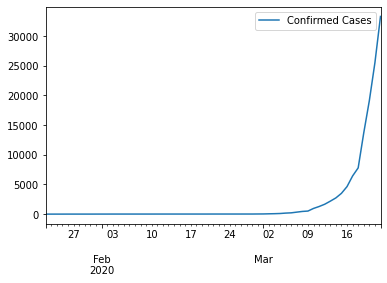

In [10]:
totals.plot()

### Viewing growth from a log scale:

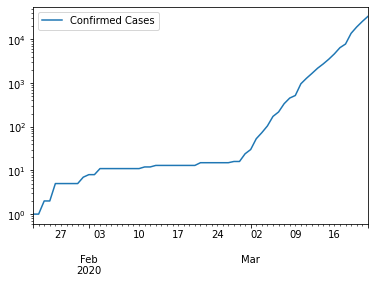

In [11]:
totals.plot(logy=True)

### Data in Numbers - US Confirmed Cases (From Feb 23rd):

In [12]:
totals = totals.loc['2020-02-28':]
totals

,Confirmed Cases
2020-02-28,16
2020-02-29,24
2020-03-01,30
2020-03-02,53
2020-03-03,73
2020-03-04,104
2020-03-05,172
2020-03-06,217
2020-03-07,336
2020-03-08,452


# Generating Lines of Best Fit:

### We can see that fitting to the data seems to work pretty well

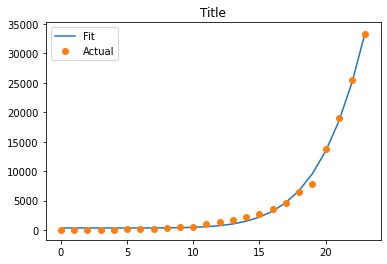

In [13]:
x = np.array(range(len(totals.index)))
y_meas = totals['Confirmed Cases'].astype(float)

# Initial guess for parameters
p0 = [0, 1, 1, 1]

# Fit equation using least squares optimization
plsq = leastsq(residuals, p0, args=(y_meas, x))

x_hat = np.array(range(len(totals.index)))
plt.plot(x_hat,peval(x_hat,plsq[0]),x,y_meas,'o')
plt.title('Title')
plt.legend(['Fit', 'Actual'], loc='upper left')

# Projections:

### Note: These projections are only estimations, and represent my opinions and mine alone. 

For Official Coronavirus information please visit https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports/

### We use a logistic growth model to calculate our projections
Unlike exponential growth, logistic growth tapers off over time:
![title](assets/logistic_growth.png)

### Plot results with predictions for ten days into the future:

In [14]:
num_pred_days = 10

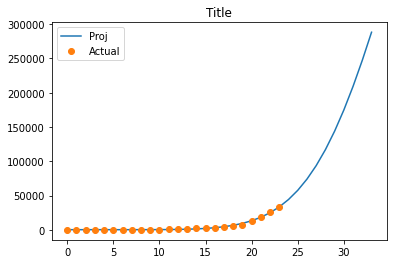

In [15]:
x_hat = np.array(range(len(totals.index) + num_pred_days))
plt.plot(x_hat,peval(x_hat,plsq[0]),x,y_meas,'o')
plt.title('Title')
plt.legend(['Proj', 'Actual'], loc='upper left')

### Projections in numbers:

In [16]:
proj = round(pd.DataFrame(peval(x_hat,plsq[0])))
proj['Actual'] = np.concatenate((np.array(y_meas), np.array([np.NaN for _ in range(num_pred_days)])), axis=0)
proj.index = [datetime.date(2020,2,28) + datetime.timedelta(days=x) for x in range(len(x_hat))]
proj.columns = ['Proj', 'Actual']
proj['Proj Growth'] = [max(list(proj['Proj'])[idx] - list(proj['Proj'])[idx - 1], 0.0) for idx, _ in enumerate(list(proj['Proj']))]
proj['Actual Growth'] = [max(y_meas[idx] - y_meas[idx - 1], 0.0) for idx, _ in enumerate(list(y_meas))] + [np.NaN for _ in range(num_pred_days)]
proj['Actual / Proj Diff'] = proj['Actual'] - proj['Proj']
proj['Actual / Proj Growth Diff'] = proj['Actual Growth'] - proj['Proj Growth']
proj.astype(object).fillna("TBD")

,Proj,Actual,Proj Growth,Actual Growth,Actual / Proj Diff,Actual / Proj Growth Diff
2020-02-28,346.0,16,0.0,0,-330,0
2020-02-29,346.0,24,0.0,8,-322,8
2020-03-01,346.0,30,0.0,6,-316,6
2020-03-02,346.0,53,0.0,23,-293,23
2020-03-03,346.0,73,0.0,20,-273,20
2020-03-04,347.0,104,1.0,31,-243,30
2020-03-05,349.0,172,2.0,68,-177,66
2020-03-06,355.0,217,6.0,45,-138,39
2020-03-07,370.0,336,15.0,119,-34,104
2020-03-08,401.0,452,31.0,116,51,85


In [17]:
print(f"The model predicts {round(proj['Proj'][datetime.date.today()])} confirmed cases by the end of today.")
print(f"The model predicts {round(proj['Proj'][-1])} confirmed cases in ten day's time.")

The model predicts 44339.0 confirmed cases by the end of today.
The model predicts 288041.0 confirmed cases in ten day's time.


# Today's end-of-day results (coming EOD):

In [18]:
# df = pd.read_csv(f'COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/{(datetime.datetime.now()).strftime("%m-%d-%Y")}.csv') 
# us = df[(df["Country/Region"]=='US')]
# us.sort_values("Province/State").reset_index(drop=True)

In [19]:
# us_totals = us.sum().to_frame().drop(["Province/State", "Country/Region", "Last Update", "Latitude", "Longitude"])
# us_totals

In [20]:
# c = us_totals[0]['Confirmed']
# d = us_totals[0]['Deaths']
# print(f'US mortality rate as of the end of today: {round((d/c) * 100, 2)}%')